In [1]:
%store -r

In [2]:
import os
import pathlib
from glob import glob
import requests

from math import floor, ceil

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr
import xrspatial

c:\Users\tjsto\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
def process_image(file_pattern, boundary_gdf, buffer=0):
    """Load image, crop to study boundary, merge assays"""
    
    # Set a buffer to crop images to
    bounds_buffer = set_buffer(boundary_gdf, buffer)
    
    # Open and crop the images
    da_list = []
    for file_path in glob(file_pattern):
        tile_da = (
            rxr.open_rasterio(file_path, mask_and_scale=True)
            .squeeze())
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        da_list.append(cropped_da)
    
    # Merge the list of cropped data arrays
    merged_da = rxrmerge.merge_arrays(da_list)
    
    # Returns a cropped and merged data array
    return merged_da

Fit a model: For each forest:

    Download model variables as raster layers covering your study area envelope, including:
        At least one soil variable from the POLARIS dataset
        Elevation from the SRTM (available from the earthaccess API)
        At least one climate variable from the MACAv2 THREDDS data server. Your project should compare two climate scenarios of your choice (e.g. different time periods, different emission scenarios). You can find a tutorial on how to access these climate data on earthdatascience.org


In [5]:
def download_tif(url, save_path):
    """Function to download and save .tif files"""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Downloaded: {save_path}")
    else: 
        print(f"Failed to download {url}. Status code: {response.status_code}")

In [6]:
def polaris_soil_data(variable, statistic, depth, gdf, save_folder):
    
    # Ensure the save directory exists
    polaris_dir = os.path.join(data_dir, 'polaris/'+save_folder)
    os.makedirs(polaris_dir, exist_ok=True)

    # Create list of soil data URLs
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
                "/{variable}"
                "/{statistic}"
                "/{depth}"
                "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
        gdf.total_bounds)

    soil_url_list = []

    for lesser_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        for lesser_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
            soil_url = soil_url_template.format(
                variable=variable,
                statistic=statistic,
                depth=depth,
                min_lat=lesser_lat, max_lat=lesser_lat+1, 
                min_lon=lesser_lon, max_lon=lesser_lon+1)
            soil_url_list.append(soil_url)

    # Download the files locally
    for url in soil_url_list:
        # Extract file name from url
        split_url = url.split("/")[-5:]
        filename = ''
        for i in split_url:
            filename+=i

        # Download the .tif file once
        save_path = os.path.join(polaris_dir, filename)
        if not os.path.exists(save_path):
            download_tif(url, save_path, buffer)


GWNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', GWNF_gdf, 'GWNF')
JNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', JNF_gdf, 'JNF')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

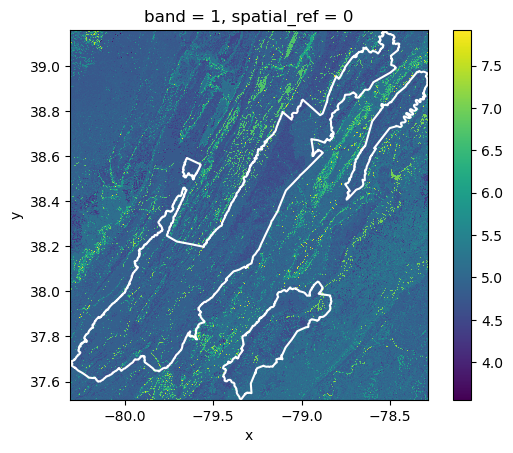

In [7]:
GWNF_soil_path = os.path.join(data_dir, 'polaris\GWNF\*.tif')
GWNF_ph_da = process_image(GWNF_soil_path, GWNF_gdf)
GWNF_ph_da.plot()
GWNF_gdf.boundary.plot(ax=plt.gca(), color='white')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

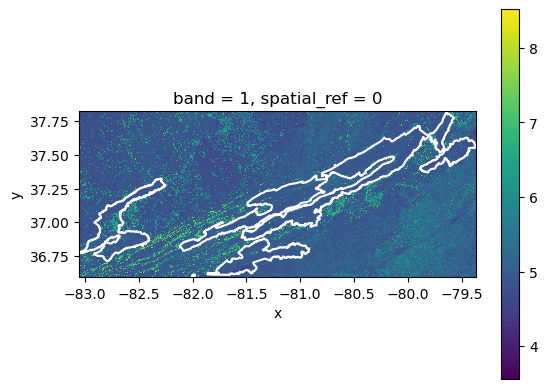

In [8]:
JNF_soil_path = os.path.join(data_dir, 'polaris\JNF\*.tif')
JNF_ph_da = process_image(JNF_soil_path, JNF_gdf)
JNF_ph_da.plot()
JNF_gdf.boundary.plot(ax=plt.gca(), color='white')